In [1]:
%matplotlib inline
import numpy as np
from scipy import stats, interpolate
from blimpy import Waterfall
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm
import dask.array as da
import h5py as h5
import os

from utils import *

fil_path = "data/filterbanks/"
h5_path = "data/h5/"

test_fil = fil_path + "blc20_guppi_57991_48899_3C161_0007.gpuspec.0000.fil"

fri_obs = h5_path + "GBT_57532_09539_HIP56445_fine.h5"

In [2]:
# Show Info
wf = Waterfall(fri_obs, load_data=False)
wf.info()

blimpy.file_wrapper INFO     Skipping loading data ...

--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16,

/Users/yuhongc/PycharmProjects/BSRC_Env/lib/python3.6/site-packages/blimpy/file_wrapper.py:326: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(self.filename)


In [3]:
coarse_channel_width = np.int(np.round(187.5/64/abs(wf.header[b'foff'])))
coarse_channel_width

1033216

freqs, data = wf.grab_data(f_start=0, f_stop=1070)
print(data.shape)
freqs = freqs[::-1]
data = data[:,::-1]

data = data[:, :15 * coarse_channel_width]
freqs = freqs[:15 * coarse_channel_width]

integrated = np.sum(data, axis=0)/len(data)
for n in np.nonzero(integrated > 10**13):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
plt.figure()
plt.plot(freqs[:15*1033216], np.log(integrated))

channels = np.reshape(integrated, (-1, coarse_channel_width))

# plot spectrum and selected channel (logged)

channel_ind = 4
chan_freqs = freqs[coarse_channel_width * channel_ind: coarse_channel_width * (channel_ind+1)]
plt.figure()
plt.plot(freqs[:15*coarse_channel_width], np.log(integrated))


plt.plot(chan_freqs, np.log(channels[channel_ind]))

plt.figure()
plt.plot(chan_freqs, channels[channel_ind])

Downsampling by a factor of (1, 3531)


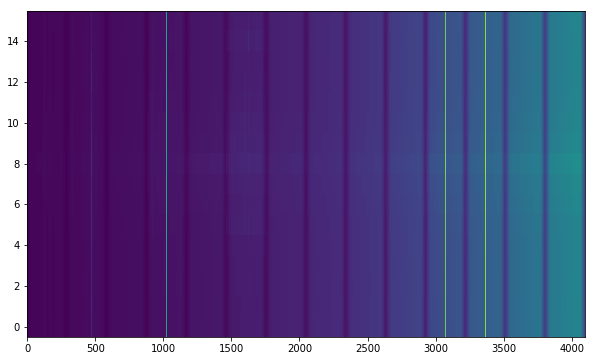

In [7]:
orig_block1 = np.load("GBT_57532_09539_HIP56445_fine/original/0.npy")
orig_block1 = orig_block1[:,0,:]
plot_segment(orig_block1)

Downsampling by a factor of (1, 3531)
(16, 14465024)


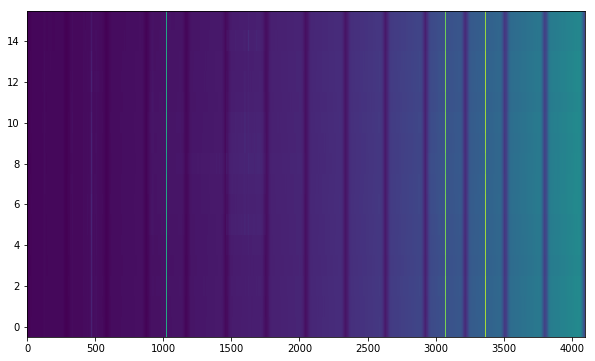

In [8]:
block1 = np.load("GBT_57532_09539_HIP56445_fine/normalized/0.npy")
block2 = np.load("GBT_57532_09539_HIP56445_fine/normalized/1.npy")

block1 = block1[:, 0, :]
block2 = block2[:, 0, :]

plot_segment(block1)
print(block1.shape)

In [9]:
integrated = np.mean(block1, axis=0)
for n in np.nonzero(integrated > 800):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
channels = np.reshape(integrated, (-1, coarse_channel_width))
channels.shape

(14, 1033216)

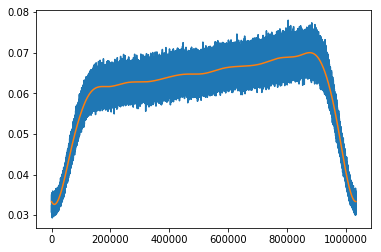

In [10]:
order = 16
channel_ind = 7
x = np.arange(coarse_channel_width)
knots = np.arange(0, coarse_channel_width, coarse_channel_width//order+1)
spl = interpolate.splrep(x, channels[channel_ind], t=knots[1:])
chan_fit = interpolate.splev(x, spl)

plt.figure()
plt.plot(x, channels[channel_ind])
plt.plot(x, chan_fit)

In [ ]:
residuals = channels[channel_ind] - chan_fit
plt.figure()
plt.plot(x, residuals)

In [ ]:
norm_chan = block1[:, channel_ind*coarse_channel_width:(channel_ind+1)*coarse_channel_width] - chan_fit

norm_chan[norm_chan > 800] = 0
    
plot_segment(norm_chan)

In [ ]:
fit_1 = fit_channel_bandpass(block1[:, :coarse_channel_width], channels[0])

In [ ]:
np.allclose(norm_chan0, block1[:, :coarse_channel_width]-chan_fit)

In [ ]:
np.allclose(norm_chan0, remove_channel_bandpass(block1[:, :coarse_channel_width], channels[0]))

In [ ]:
remove_channel_bandpass(block1[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind])

In [ ]:
def clean(channel_ind):
        return remove_channel_bandpass(block1[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind], coarse_channel_width)

def normalize_block():
    from multiprocessing import Pool
    with Pool(12) as p:
        cleaned = p.map(clean, range(14))
    return cleaned

In [ ]:
normalized = normalize_block()

In [ ]:
plot_segment(normalized)

In [ ]:
np.concatenate(normalized, axis=1).shape == block1.shape

In [6]:
blocks = [block1]

In [14]:
for block in blocks:
    from multiprocessing import Pool, current_process
    def clean(channel_ind):
        print(current_process().name)
        return remove_channel_bandpass(block[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind], coarse_channel_width)

    def normalize_block():
        with Pool(12) as p:
            cleaned = p.map(clean, range(14))
        return cleaned
    normalized = normalize_block()
    normalized = np.concatenate(normalized, axis=1)

ForkPoolWorker-91
ForkPoolWorker-89
ForkPoolWorker-86
ForkPoolWorker-90
ForkPoolWorker-87
ForkPoolWorker-85
ForkPoolWorker-92
ForkPoolWorker-88
ForkPoolWorker-95
ForkPoolWorker-94
ForkPoolWorker-93
ForkPoolWorker-96
ForkPoolWorker-87
ForkPoolWorker-94


In [ ]:
plot_data = normalized[:, 1400*3531:1700*3531]
plot_data[plot_data > 900]=0
plot_segment(plot_data)

In [ ]:
plot_data = block1[:, 1530*3531:1540*3531]
plot_segment(plot_data)

In [ ]:
plt.imshow(plot_data, aspect="auto")

In [15]:
import os
source_dir = "normalized_a/"
blocks = os.listdir(source_dir)
blocks

['20.npy',
 '21.npy',
 '19.npy',
 '18.npy',
 '5.npy',
 '4.npy',
 '6.npy',
 '7.npy',
 '3.npy',
 '2.npy',
 '0.npy',
 '1.npy',
 'info',
 '9.npy',
 '8.npy',
 '15.npy',
 '14.npy',
 '16.npy',
 '17.npy',
 '13.npy',
 '12.npy',
 '10.npy',
 '11.npy']

In [18]:
for block in blocks[:2]:
    print("loading %s from %s" % (block, source_dir))
    block_data = np.load(source_dir+block)
    block_data = block_data[:, 0, :]
    integrated = np.mean(block1, axis=0)
    for n in np.nonzero(integrated > 800):
        integrated[n] = (integrated[n-1] + integrated[n+1]) /2
    channels = np.reshape(integrated, (-1, coarse_channel_width))
    
    
    from multiprocessing import Pool, current_process
    def clean(channel_ind):
        print(current_process().name)
        return remove_channel_bandpass(block_data[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind], coarse_channel_width)

    def normalize_block():
        with Pool(12) as p:
            cleaned = p.map(clean, range(14))
        return cleaned
    normalized = normalize_block()
    normalized = np.concatenate(normalized, axis=1)

loading 20.npy from normalized_a/
ForkPoolWorker-121
ForkPoolWorker-124
ForkPoolWorker-123
ForkPoolWorker-128
ForkPoolWorker-126
ForkPoolWorker-125
ForkPoolWorker-122
ForkPoolWorker-127
ForkPoolWorker-129
ForkPoolWorker-131
ForkPoolWorker-130
ForkPoolWorker-132
ForkPoolWorker-128
ForkPoolWorker-129
loading 21.npy from normalized_a/
ForkPoolWorker-133
ForkPoolWorker-136
ForkPoolWorker-135
ForkPoolWorker-134
ForkPoolWorker-140
ForkPoolWorker-142
ForkPoolWorker-138
ForkPoolWorker-143
ForkPoolWorker-141
ForkPoolWorker-139
ForkPoolWorker-137
ForkPoolWorker-144
ForkPoolWorker-135
ForkPoolWorker-134


In [19]:
block

'21.npy'

In [20]:
np.save("clean"+block, normalized)